In [46]:
print('hello')

hello


In [47]:
! pip3 install nltk

In [48]:
import time 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# worldcloud
import random
from wordcloud import WordCloud


In [49]:
# Download NLTK resources (only needed once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/albertschool/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/albertschool/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/albertschool/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [50]:
# retrieving the datasets we used for the last notebook

raw_path = '/Users/albertschool/albert-hod-shared/data/olist_datasets/'

df_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
df_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
df_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
df_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
df_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
df_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
df_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
df_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')


# I - Sentiment analysis of customer reviews

## A - Reminders on the Review dataframe

In [51]:
# checking that df_order_reviews is loaded

df_order_reviews.head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14 00:00:00,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17 00:00:00,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


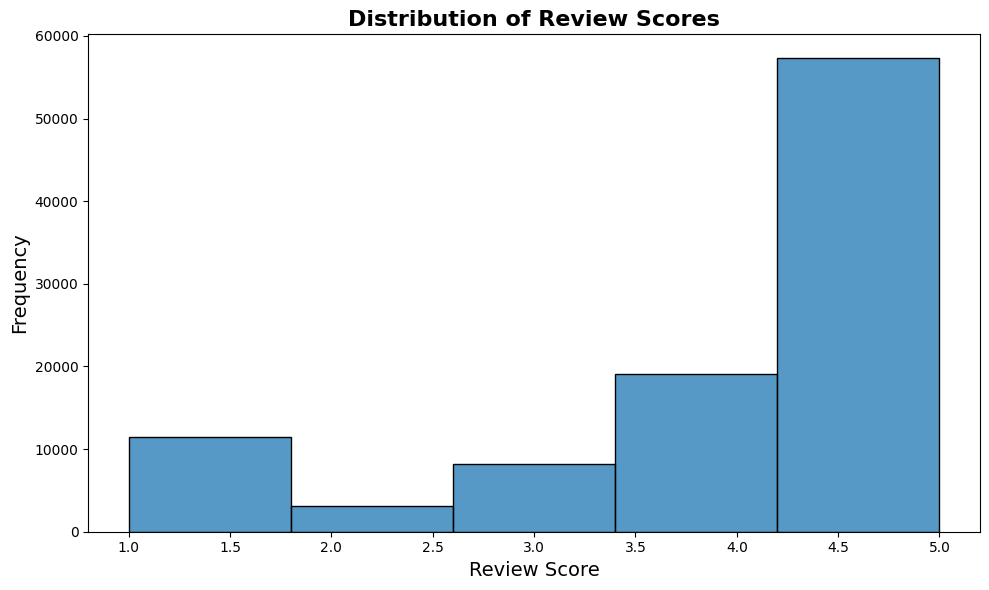

In [52]:
# Create a distribution plot (dist plot) with seaborn on the review score

# "professional" colors
colors = ['#2C3E50', '#E74C3C', '#ECF0F1', '#3498DB', '#2ECC71', '#F1C40F', '#9B59B6']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create histogram with seaborn
ax = sns.histplot(data=df_order_reviews, 
            x='review_score',
            bins=5,
            edgecolor='black',
            stat='count')

# Customizing the plot
plt.title('Distribution of Review Scores', fontsize=16, fontweight='bold')
plt.xlabel('Review Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Ajuster les marges
plt.tight_layout()

# Show the plot
plt.show();


In [53]:
# Check for missing values in review comments
missing_summary = df_order_reviews[['review_comment_title', 'review_comment_message']].isnull().sum()
print(missing_summary)


# Filter out rows with missing comments
# Keep only rows where both comment title and message are present
df_clean_comments = df_order_reviews[
    df_order_reviews['review_comment_title'].notnull() & 
    df_order_reviews['review_comment_message'].notnull()
]
df_clean_comments

review_comment_title      87656
review_comment_message    58247
dtype: int64


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01
19,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37
22,d21bbc789670eab777d27372ab9094cc,4fc44d78867142c627497b60a7e0228a,5,Ótimo,Loja nota 10,2018-07-10 00:00:00,2018-07-11 14:10:25
34,c92cdd7dd544a01aa35137f901669cdf,37e7875cdce5a9e5b3a692971f370151,4,Muito bom.,Recebi exatamente o que esperava. As demais en...,2018-06-07 00:00:00,2018-06-09 18:44:02
...,...,...,...,...,...,...,...
99187,47e0954e156dac6512c25c6d2ecc1c66,16cbf959cfdb88c47ee2a29303547ec2,5,Nota máxima!,"Muito obrigado,\r\n\r\nExcelente atendimento,b...",2018-05-22 00:00:00,2018-05-23 00:51:43
99192,0e7bc73fde6782891898ea71443f9904,bd78f91afbb1ecbc6124974c5e813043,4,👍,Aprovado!,2018-07-04 00:00:00,2018-07-05 00:25:13
99196,58be140ccdc12e8908ff7fd2ba5c7cb0,0ebf8e35b9807ee2d717922d5663ccdb,5,muito bom produto,"Ficamos muito satisfeitos com o produto, atend...",2018-06-30 00:00:00,2018-07-02 23:09:35
99197,51de4e06a6b701cb2be47ea0e689437b,b7467ae483dbe956fe9acdf0b1e6e3f4,3,Não foi entregue o pedido,Bom dia \r\nDas 6 unidades compradas só recebi...,2018-06-05 00:00:00,2018-06-06 10:52:19


In [54]:
# Create a new column to categorize reviews as positive, neutral, or negative
def categorize_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score < 3:
        return 'negative' 
    else:
        return 'neutral'

# apply the function to the dataframe
df_order_reviews['sentiment'] = df_order_reviews['review_score'].apply(categorize_sentiment)
df_order_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,sentiment
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,positive
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,positive
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,positive
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,positive
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,positive
...,...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30,positive
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42,positive
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,positive
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13,positive


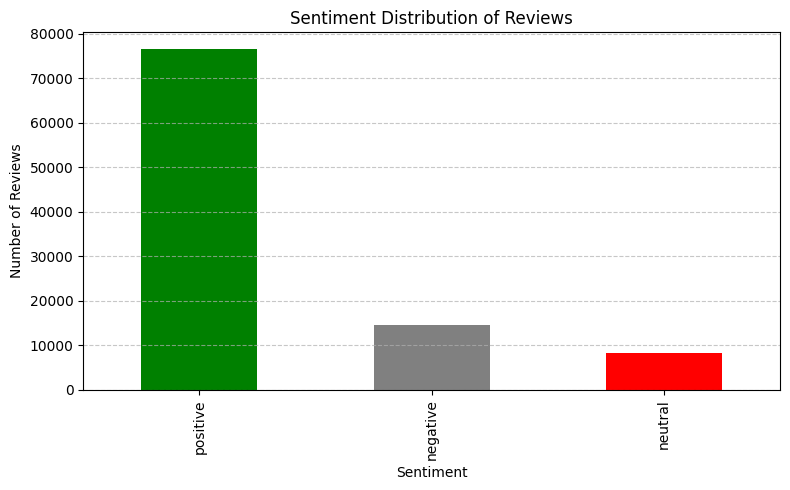

In [55]:
# Visualize the sentiment distribution - how many reviews by categories?

# Count number of reviews in each sentiment category
sentiment_counts = df_order_reviews['sentiment'].value_counts()

# Plotting
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])

plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




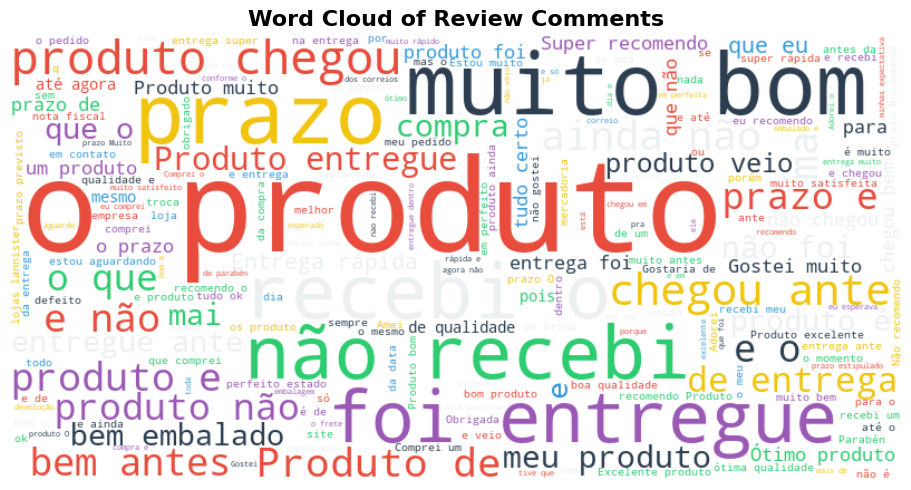

In [56]:
## Wordcloud

# Create a wordcloud on orders with negative reviews only

# Define a color function
def color_func(word, font_size, position, orientation, random_state=42, **kwargs):
    return random.choice(colors)

# Example: Word cloud from review comments
plt.figure(figsize=(10, 5))

# every order
#wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(' '.join(df['review_comment_message'].dropna()))

# only negative reviews
#reviews_with_negative_comments = reviews_with_comments[reviews_with_comments.review_score < 3]
wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func)
wordcloud.generate(' '.join(df_order_reviews['review_comment_message'].dropna()))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud of Review Comments', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


## B - Text Preprocessing and conversion to numerical features

### 1 - Cleaning a small sample of the data and looking at the results

In [57]:
# create a new sample dataframe, that will be a sample of df_order_reviews
# which only have non null review_comment_messages
# which only contains review_id, review_score, review_comment_message

df_comments= df_order_reviews[df_order_reviews['review_comment_message'].notnull()]
df_sample = df_comments[['review_id','review_score','review_comment_message']]
df_sample.sample(20)


,review_id,review_score,review_comment_message
40304,84c2cb96ac37d1a38d507cf8dd0ba949,4,Produto entregue no prazo e de acordo.
20695,f6ec5582f4c94ad60827bc59cd7bec45,3,"Um pouco demorada a entrega, mas antes do praz..."
55617,9eddce65a39ebef2765cc8e97a983218,1,Preciso efetuar a troca enviei msg e nada de r...
38091,c93a6b5373c1d827de84ec782fa140fd,5,Recomento! Entrega pontual.
9253,691cdce37ba6a28581a102e94f9b9824,5,Ótima malas bem reforçadas recomendaria
60809,fb1c906a80706da9a702c724a31dfd49,2,Produto veio sujo e mal acabado
76991,eb632ac43fa0e0b1455adde073a04d0f,5,Muito bom
78970,46725bae865a43c83b6a17c4f483613c,4,Produto de qualidade boa.\r\nGostei.\r\n\r\n\r\n
5506,bc9873bc1e70f97974b02333648fad87,5,"Boa parceira, meu produto chegou antes do prazo."
79501,94284941c9afacb60342d3c0869924cc,5,"Tudo ocorreu muito bem,"


In [58]:
# create a new comment_clean column which makes the text LOWER (no uppercases)

df_sample['comment_clean'] = df_sample['comment_clean'] = df_order_reviews['review_comment_message'].apply(
    lambda x: x.lower() if isinstance(x, str) else x
)

df_sample


/var/folders/hy/m34w8mzj657f1_3lhxh7vfzh0000gp/T/ipykernel_13779/1744916057.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['comment_clean'] = df_sample['comment_clean'] = df_order_reviews['review_comment_message'].apply(


,review_id,review_score,review_comment_message,comment_clean
3,e64fb393e7b32834bb789ff8bb30750e,5,Recebi bem antes do prazo estipulado.,recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,5,Parabéns lojas lannister adorei comprar pela I...,parabéns lojas lannister adorei comprar pela i...
9,8670d52e15e00043ae7de4c01cc2fe06,4,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente. no site a marca do aparelh...
12,4b49719c8a200003f700d3d986ea1a19,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","mas um pouco ,travando...pelo valor ta boa.\r\n"
15,3948b09f7c818e2d86c9a546758b2335,5,"Vendedor confiável, produto ok e entrega antes...","vendedor confiável, produto ok e entrega antes..."
...,...,...,...,...
99205,98fffa80dc9acbde7388bef1600f3b15,4,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a compr...
99208,df5fae90e85354241d5d64a8955b2b09,5,Entregou dentro do prazo. O produto chegou em ...,entregou dentro do prazo. o produto chegou em ...
99215,a709d176f59bc3af77f4149c96bae357,3,"O produto não foi enviado com NF, não existe v...","o produto não foi enviado com nf, não existe v..."
99221,b3de70c89b1510c4cd3d0649fd302472,5,"Excelente mochila, entrega super rápida. Super...","excelente mochila, entrega super rápida. super..."


In [59]:
# remove the special characters using a simple regex function

df_sample['comment_clean'] = df_sample['comment_clean'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
df_sample


/var/folders/hy/m34w8mzj657f1_3lhxh7vfzh0000gp/T/ipykernel_13779/4121247333.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['comment_clean'] = df_sample['comment_clean'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))


,review_id,review_score,review_comment_message,comment_clean
3,e64fb393e7b32834bb789ff8bb30750e,5,Recebi bem antes do prazo estipulado.,recebi bem antes do prazo estipulado
4,f7c4243c7fe1938f181bec41a392bdeb,5,Parabéns lojas lannister adorei comprar pela I...,parabns lojas lannister adorei comprar pela in...
9,8670d52e15e00043ae7de4c01cc2fe06,4,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente no site a marca do aparelho...
12,4b49719c8a200003f700d3d986ea1a19,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",mas um pouco travandopelo valor ta boa\r\n
15,3948b09f7c818e2d86c9a546758b2335,5,"Vendedor confiável, produto ok e entrega antes...",vendedor confivel produto ok e entrega antes d...
...,...,...,...,...
99205,98fffa80dc9acbde7388bef1600f3b15,4,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a compr...
99208,df5fae90e85354241d5d64a8955b2b09,5,Entregou dentro do prazo. O produto chegou em ...,entregou dentro do prazo o produto chegou em c...
99215,a709d176f59bc3af77f4149c96bae357,3,"O produto não foi enviado com NF, não existe v...",o produto no foi enviado com nf no existe vend...
99221,b3de70c89b1510c4cd3d0649fd302472,5,"Excelente mochila, entrega super rápida. Super...",excelente mochila entrega super rpida super re...


In [60]:
# tokenize the text - meaning, isolate all words into a list, using the NLTK library, and another column - comment_clean_tokenized

df_sample['comment_clean_tokenized'] = df_sample['comment_clean'].apply(
    lambda x: nltk.word_tokenize(x, language='portuguese') if isinstance(x, str) else x
)
df_sample
    

/var/folders/hy/m34w8mzj657f1_3lhxh7vfzh0000gp/T/ipykernel_13779/1363874992.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['comment_clean_tokenized'] = df_sample['comment_clean'].apply(


,review_id,review_score,review_comment_message,comment_clean,comment_clean_tokenized
3,e64fb393e7b32834bb789ff8bb30750e,5,Recebi bem antes do prazo estipulado.,recebi bem antes do prazo estipulado,"[recebi, bem, antes, do, prazo, estipulado]"
4,f7c4243c7fe1938f181bec41a392bdeb,5,Parabéns lojas lannister adorei comprar pela I...,parabns lojas lannister adorei comprar pela in...,"[parabns, lojas, lannister, adorei, comprar, p..."
9,8670d52e15e00043ae7de4c01cc2fe06,4,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente no site a marca do aparelho...,"[aparelho, eficiente, no, site, a, marca, do, ..."
12,4b49719c8a200003f700d3d986ea1a19,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",mas um pouco travandopelo valor ta boa\r\n,"[mas, um, pouco, travandopelo, valor, ta, boa]"
15,3948b09f7c818e2d86c9a546758b2335,5,"Vendedor confiável, produto ok e entrega antes...",vendedor confivel produto ok e entrega antes d...,"[vendedor, confivel, produto, ok, e, entrega, ..."
...,...,...,...,...,...
99205,98fffa80dc9acbde7388bef1600f3b15,4,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a compr...,"[para, este, produto, recebi, de, acordo, com,..."
99208,df5fae90e85354241d5d64a8955b2b09,5,Entregou dentro do prazo. O produto chegou em ...,entregou dentro do prazo o produto chegou em c...,"[entregou, dentro, do, prazo, o, produto, cheg..."
99215,a709d176f59bc3af77f4149c96bae357,3,"O produto não foi enviado com NF, não existe v...",o produto no foi enviado com nf no existe vend...,"[o, produto, no, foi, enviado, com, nf, no, ex..."
99221,b3de70c89b1510c4cd3d0649fd302472,5,"Excelente mochila, entrega super rápida. Super...",excelente mochila entrega super rpida super re...,"[excelente, mochila, entrega, super, rpida, su..."


In [61]:
# then remove the stopwords using the portuguese library from NLTK

# Portuguese stopwords list
stop_words = set(stopwords.words('portuguese'))

# Remove stopwords from tokenized comments
df_sample['comment_clean_tokenized'] = df_sample['comment_clean_tokenized'].apply(
    lambda tokens: [word for word in tokens if word not in stop_words] if isinstance(tokens, list) else tokens
)
df_sample

/var/folders/hy/m34w8mzj657f1_3lhxh7vfzh0000gp/T/ipykernel_13779/1360481748.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['comment_clean_tokenized'] = df_sample['comment_clean_tokenized'].apply(


,review_id,review_score,review_comment_message,comment_clean,comment_clean_tokenized
3,e64fb393e7b32834bb789ff8bb30750e,5,Recebi bem antes do prazo estipulado.,recebi bem antes do prazo estipulado,"[recebi, bem, antes, prazo, estipulado]"
4,f7c4243c7fe1938f181bec41a392bdeb,5,Parabéns lojas lannister adorei comprar pela I...,parabns lojas lannister adorei comprar pela in...,"[parabns, lojas, lannister, adorei, comprar, i..."
9,8670d52e15e00043ae7de4c01cc2fe06,4,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente no site a marca do aparelho...,"[aparelho, eficiente, site, marca, aparelho, i..."
12,4b49719c8a200003f700d3d986ea1a19,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",mas um pouco travandopelo valor ta boa\r\n,"[pouco, travandopelo, valor, ta, boa]"
15,3948b09f7c818e2d86c9a546758b2335,5,"Vendedor confiável, produto ok e entrega antes...",vendedor confivel produto ok e entrega antes d...,"[vendedor, confivel, produto, ok, entrega, ant..."
...,...,...,...,...,...
99205,98fffa80dc9acbde7388bef1600f3b15,4,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a compr...,"[produto, recebi, acordo, compra, realizada]"
99208,df5fae90e85354241d5d64a8955b2b09,5,Entregou dentro do prazo. O produto chegou em ...,entregou dentro do prazo o produto chegou em c...,"[entregou, dentro, prazo, produto, chegou, con..."
99215,a709d176f59bc3af77f4149c96bae357,3,"O produto não foi enviado com NF, não existe v...",o produto no foi enviado com nf no existe vend...,"[produto, enviado, nf, existe, venda, nf, cert..."
99221,b3de70c89b1510c4cd3d0649fd302472,5,"Excelente mochila, entrega super rápida. Super...",excelente mochila entrega super rpida super re...,"[excelente, mochila, entrega, super, rpida, su..."


In [62]:
# Use stemming to shorten the words as much as possible using another column - comment_clean_stemmed

stemmer = PorterStemmer()

df_sample['comment_clean_stemmed'] = df_sample['comment_clean_tokenized'].apply(
    lambda tokens: [stemmer.stem(word) for word in tokens] if isinstance(tokens, list) else tokens
)
df_sample

/var/folders/hy/m34w8mzj657f1_3lhxh7vfzh0000gp/T/ipykernel_13779/2608933529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['comment_clean_stemmed'] = df_sample['comment_clean_tokenized'].apply(


,review_id,review_score,review_comment_message,comment_clean,comment_clean_tokenized,comment_clean_stemmed
3,e64fb393e7b32834bb789ff8bb30750e,5,Recebi bem antes do prazo estipulado.,recebi bem antes do prazo estipulado,"[recebi, bem, antes, prazo, estipulado]","[recebi, bem, ant, prazo, estipulado]"
4,f7c4243c7fe1938f181bec41a392bdeb,5,Parabéns lojas lannister adorei comprar pela I...,parabns lojas lannister adorei comprar pela in...,"[parabns, lojas, lannister, adorei, comprar, i...","[parabn, loja, lannist, adorei, comprar, inter..."
9,8670d52e15e00043ae7de4c01cc2fe06,4,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente no site a marca do aparelho...,"[aparelho, eficiente, site, marca, aparelho, i...","[aparelho, eficient, site, marca, aparelho, im..."
12,4b49719c8a200003f700d3d986ea1a19,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",mas um pouco travandopelo valor ta boa\r\n,"[pouco, travandopelo, valor, ta, boa]","[pouco, travandopelo, valor, ta, boa]"
15,3948b09f7c818e2d86c9a546758b2335,5,"Vendedor confiável, produto ok e entrega antes...",vendedor confivel produto ok e entrega antes d...,"[vendedor, confivel, produto, ok, entrega, ant...","[vendedor, confivel, produto, ok, entrega, ant..."
...,...,...,...,...,...,...
99205,98fffa80dc9acbde7388bef1600f3b15,4,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a compr...,"[produto, recebi, acordo, compra, realizada]","[produto, recebi, acordo, compra, realizada]"
99208,df5fae90e85354241d5d64a8955b2b09,5,Entregou dentro do prazo. O produto chegou em ...,entregou dentro do prazo o produto chegou em c...,"[entregou, dentro, prazo, produto, chegou, con...","[entreg, dentro, prazo, produto, chegou, condi..."
99215,a709d176f59bc3af77f4149c96bae357,3,"O produto não foi enviado com NF, não existe v...",o produto no foi enviado com nf no existe vend...,"[produto, enviado, nf, existe, venda, nf, cert...","[produto, enviado, nf, exist, venda, nf, certe..."
99221,b3de70c89b1510c4cd3d0649fd302472,5,"Excelente mochila, entrega super rápida. Super...",excelente mochila entrega super rpida super re...,"[excelente, mochila, entrega, super, rpida, su...","[excelent, mochila, entrega, super, rpida, sup..."


### 2 - Text preprocessing

In [63]:
# Define a function to clean and preprocess text
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters, numbers, and punctuation
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Tokenize the text
        from nltk.tokenize import word_tokenize
        tokens = word_tokenize(text, language='portuguese')
        
        # Remove stopwords (Portuguese)
        tokens = [word for word in tokens if word not in stop_words]
        
        # Stemming
        tokens = [stemmer.stem(word) for word in tokens]
        
        # Join tokens back into a string
        cleaned_text = ' '.join(tokens)
        
        return cleaned_text
    else:
        return ''  # Return empty string for non-string inputs


In [64]:
# Apply preprocessing to the review comments
df_order_reviews['comment_cleaned'] = df_order_reviews['review_comment_message'].apply(preprocess_text)

# Show the first few rows to check the results
df_order_reviews[['review_comment_message', 'comment_cleaned']].head()



,review_comment_message,comment_cleaned
0,NaN,
1,NaN,
2,NaN,
3,Recebi bem antes do prazo estipulado.,recebi bem ant prazo estipulado
4,Parabéns lojas lannister adorei comprar pela I...,parabn loja lannist adorei comprar internet se...


In [65]:
# Display a sample of original and processed comments

df_order_reviews[['review_comment_message', 'comment_cleaned']].sample(10)



,review_comment_message,comment_cleaned
71651,NaN,
63353,Achei o tamanho muito pequeno,achei tamanho pequeno
63862,Produto de qualidade. Conforme a descrição.,produto qualidad conform descrio
54847,NaN,
26107,NaN,
50344,NaN,
80780,NaN,
17617,NaN,
54767,NaN,
62268,NaN,


### 3 - Final preparation steps

In [66]:
# Split the data into training and testing sets

X = df_order_reviews['comment_cleaned']  # Features (preprocessed comments)
y = df_order_reviews['sentiment']     # Labels (review score)

# Split with 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the size of the splits
print(f'Training set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')

Training set size: 79379
Test set size: 19845


## C - Building a Simple Naive Bayes Model

In [67]:
# Use CountVectorizer to convert text to a matrix of token counts
count_vectorizer = CountVectorizer(max_features=5000)  # Limit to top 5000 features

# Fit on training data and transform it
X_train_counts = count_vectorizer.fit_transform(X_train)

# Only transform test data (do not fit again)
X_test_counts = count_vectorizer.transform(X_test)

print(f"Shape of training features: {X_train_counts.shape}")
print(f"Shape of testing features: {X_test_counts.shape}")


Shape of training features: (79379, 5000)
Shape of testing features: (19845, 5000)


In [68]:
# understanding what we just did

# Some computation to find an interesting extract to look at
word_freq = X_train_counts.sum(axis=0).A1  # converting the matrix into an A1 array
word_indices = word_freq.argsort()[-10:][::-1]  # 10 most frequent words
top_feature_names = [count_vectorizer.get_feature_names_out()[i] for i in word_indices]

# creating a sample with 10 most frequent words + 5 first reviews
df_sample = pd.DataFrame(
    X_train_counts[:5, word_indices].toarray(),
    columns=top_feature_names
)

print("Displaying an extract of the bag-of-words matrix (5 first comments, 10 most frequent words):")
df_sample

Displaying an extract of the bag-of-words matrix (5 first comments, 10 most frequent words):


,produto,prazo,entrega,ant,chegou,recebi,bom,recomendo,entregu,veio
0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [69]:
# Train a Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the model on the training data
nb_classifier.fit(X_train_counts, y_train)

MultinomialNB()

In [70]:
# Make predictions on the test set
y_pred = nb_classifier.predict(X_test_counts)

In [71]:
# Evaluate the model

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report (precision, recall, f1-score for each class)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8340

Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.54      0.64      3003
     neutral       0.27      0.10      0.14      1645
    positive       0.86      0.97      0.91     15197

    accuracy                           0.83     19845
   macro avg       0.64      0.54      0.56     19845
weighted avg       0.80      0.83      0.81     19845


Confusion Matrix:
[[ 1630   221  1152]
 [  237   159  1249]
 [  222   214 14761]]


In [72]:
# Display classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

    negative       0.78      0.54      0.64      3003
     neutral       0.27      0.10      0.14      1645
    positive       0.86      0.97      0.91     15197

    accuracy                           0.83     19845
   macro avg       0.64      0.54      0.56     19845
weighted avg       0.80      0.83      0.81     19845



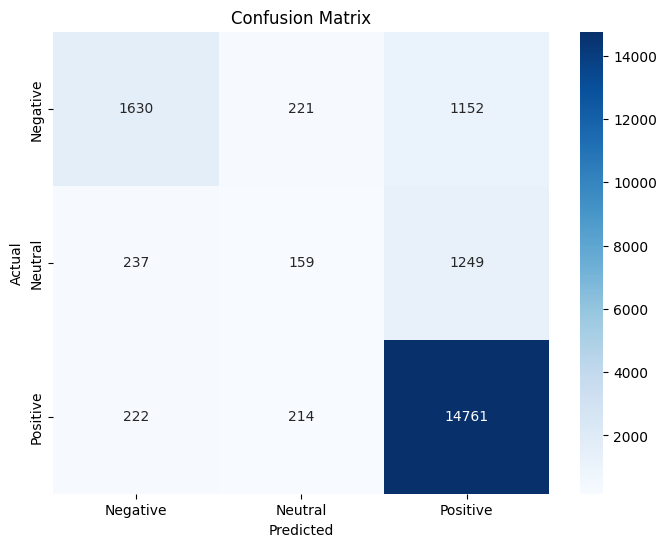

In [73]:
# Create and display confusion matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## D - Building a More Advanced Model - Logistic Regression with TF-IDF

In [74]:
# Use TF-IDF Vectorizer for better feature extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data (no fitting, only transforming)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [75]:
# Train a Logistic Regression classifier
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on the training data
lr_classifier.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [76]:
# Make predictions on the test set

# Make predictions on the test set
y_pred_lr = lr_classifier.predict(X_test_tfidf)

# Evaluate the model

# Accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy_lr:.4f}")

# Classification report (precision, recall, f1-score for each class)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print("\nConfusion Matrix:")
print(conf_matrix_lr)


Accuracy: 0.8449

Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.61      0.68      3003
     neutral       0.32      0.02      0.04      1645
    positive       0.86      0.98      0.92     15197

    accuracy                           0.84     19845
   macro avg       0.65      0.54      0.55     19845
weighted avg       0.80      0.84      0.81     19845


Confusion Matrix:
[[ 1839    32  1132]
 [  301    36  1308]
 [  260    44 14893]]


In [77]:
# Display classification report

print("Classification Report:\n")
print(classification_report(y_test, y_pred_lr))

Classification Report:

              precision    recall  f1-score   support

    negative       0.77      0.61      0.68      3003
     neutral       0.32      0.02      0.04      1645
    positive       0.86      0.98      0.92     15197

    accuracy                           0.84     19845
   macro avg       0.65      0.54      0.55     19845
weighted avg       0.80      0.84      0.81     19845



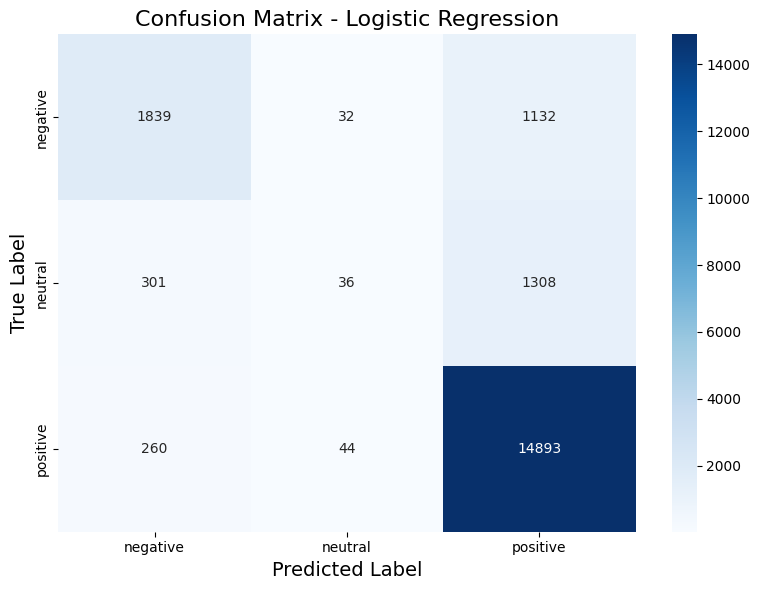

In [78]:
# Create and display confusion matrix

cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=lr_classifier.classes_, 
            yticklabels=lr_classifier.classes_)
plt.title('Confusion Matrix - Logistic Regression', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show();


In [79]:
# Get feature importance from Logistic Regression model
feature_importance = pd.DataFrame({
    'feature': tfidf_vectorizer.get_feature_names_out(),
    'importance': lr_classifier.coef_.mean(axis=0)
})

# Sort by absolute importance
feature_importance['abs_importance'] = abs(feature_importance['importance'])
feature_importance = feature_importance.sort_values('abs_importance', ascending=False)


In [80]:
# Display most important positive and negative words
print("Top 10 words associated with positive sentiment:")
positive_features = feature_importance.sort_values('importance', ascending=False).head(10)
print(positive_features[['feature', 'importance']])

print("\nTop 10 words associated with negative sentiment:")
negative_features = feature_importance.sort_values('importance', ascending=True).head(10)
print(negative_features[['feature', 'importance']])


Top 10 words associated with positive sentiment:
       feature    importance
4051    recebi  1.554312e-14
322        ant  1.406282e-14
3104       nao  1.317465e-14
1523  dinheiro  1.213844e-14
1194   consigo  1.206442e-14
2017  faltando  1.110223e-14
2425   horrvel  1.043610e-14
1488   devoluo  9.769963e-15
287       amei  8.733754e-15
1711   entrega  8.733754e-15

Top 10 words associated with negative sentiment:
         feature    importance
616          bom -3.049413e-14
4610        tima -1.746751e-14
4494       super -1.028807e-14
2765       longo -9.103829e-15
2530    inferior -8.881784e-15
4042       receb -8.511710e-15
2337    gostaria -8.363680e-15
462     atrasada -7.993606e-15
1383      demora -7.697546e-15
2940  mercadoria -7.401487e-15


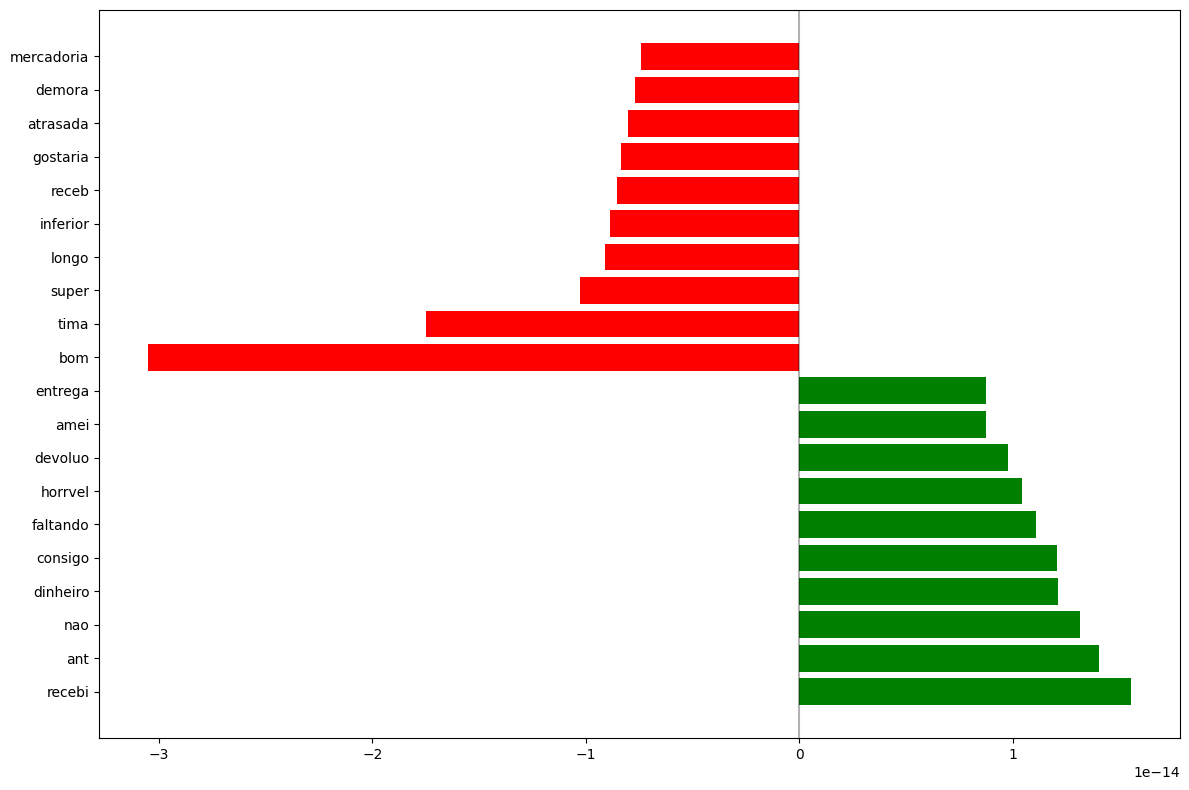

In [81]:
# Visualize top features
plt.figure(figsize=(12, 8))

top_features = pd.concat([positive_features.head(15), negative_features.head(15)])

colors = ['green' if x > 0 else 'red' for x in top_features['importance']]

# Create a bar plot
plt.barh(top_features['feature'], top_features['importance'], color=colors)

plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show();

## E - Rainforest model

In [82]:
# Start a timer to understand how long the model will last
start_time = time.time()

# Create a random forest model, while limiting the number of trees to make sure it doesn't run for too long
rf_classifier = RandomForestClassifier(
    n_estimators=100,     # number of trees in the forest
    max_depth=None,       # trees can be as deep (long) as possible
    min_samples_split=2,  # minimum split number to build a node (2 trees min to build a node)
    random_state=42,
    n_jobs=-1             # use all possible resources
)

# Use the model on the X_train TF-IDF data (same than the logistic regression)
rf_classifier.fit(X_train_tfidf, y_train)

# Predictions on the train set
y_pred_rf = rf_classifier.predict(X_test_tfidf)

# Compute execution time
training_time = time.time() - start_time
print(f"Random Forest training: {training_time:.2f} seconds")


Random Forest training: 22.27 seconds


In [83]:
# Evaluate the model

# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.4f}")

# Classification report (precision, recall, f1-score for each class)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:")
print(conf_matrix_rf)

Accuracy: 0.8414

Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.63      0.67      3003
     neutral       0.23      0.01      0.02      1645
    positive       0.86      0.97      0.91     15197

    accuracy                           0.84     19845
   macro avg       0.61      0.54      0.53     19845
weighted avg       0.79      0.84      0.80     19845


Confusion Matrix:
[[ 1882    22  1099]
 [  338    14  1293]
 [  372    24 14801]]


In [84]:
# Display the classification report

print("Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

Classification Report:

              precision    recall  f1-score   support

    negative       0.73      0.63      0.67      3003
     neutral       0.23      0.01      0.02      1645
    positive       0.86      0.97      0.91     15197

    accuracy                           0.84     19845
   macro avg       0.61      0.54      0.53     19845
weighted avg       0.79      0.84      0.80     19845



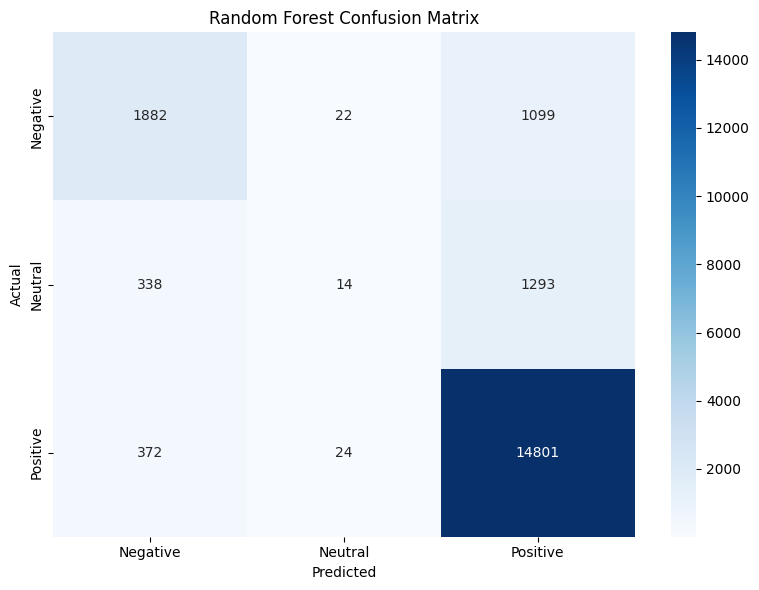

In [85]:
# Create and display the confusion matrix

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [86]:
# get the feature importance of the Random Forest model

feature_importance_rf = pd.DataFrame({
    'feature': tfidf_vectorizer.get_feature_names_out(),
    'importance': rf_classifier.feature_importances_
})

# Sort by importance
feature_importance_rf = feature_importance_rf.sort_values('importance', ascending=False)

# Display top 10 important features
print("Top 10 Most Important Features (Random Forest):")
print(feature_importance_rf.head(10))

Top 10 Most Important Features (Random Forest):
      feature  importance
4051   recebi    0.042665
3816  produto    0.033705
1099  comprei    0.027146
204     ainda    0.019329
4822     veio    0.016651
3653    prazo    0.015911
322       ant    0.014859
3104      nao    0.014805
433        at    0.011716
3424   pedido    0.009440


/var/folders/hy/m34w8mzj657f1_3lhxh7vfzh0000gp/T/ipykernel_13779/4047761605.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_features_rf, palette='pastel')


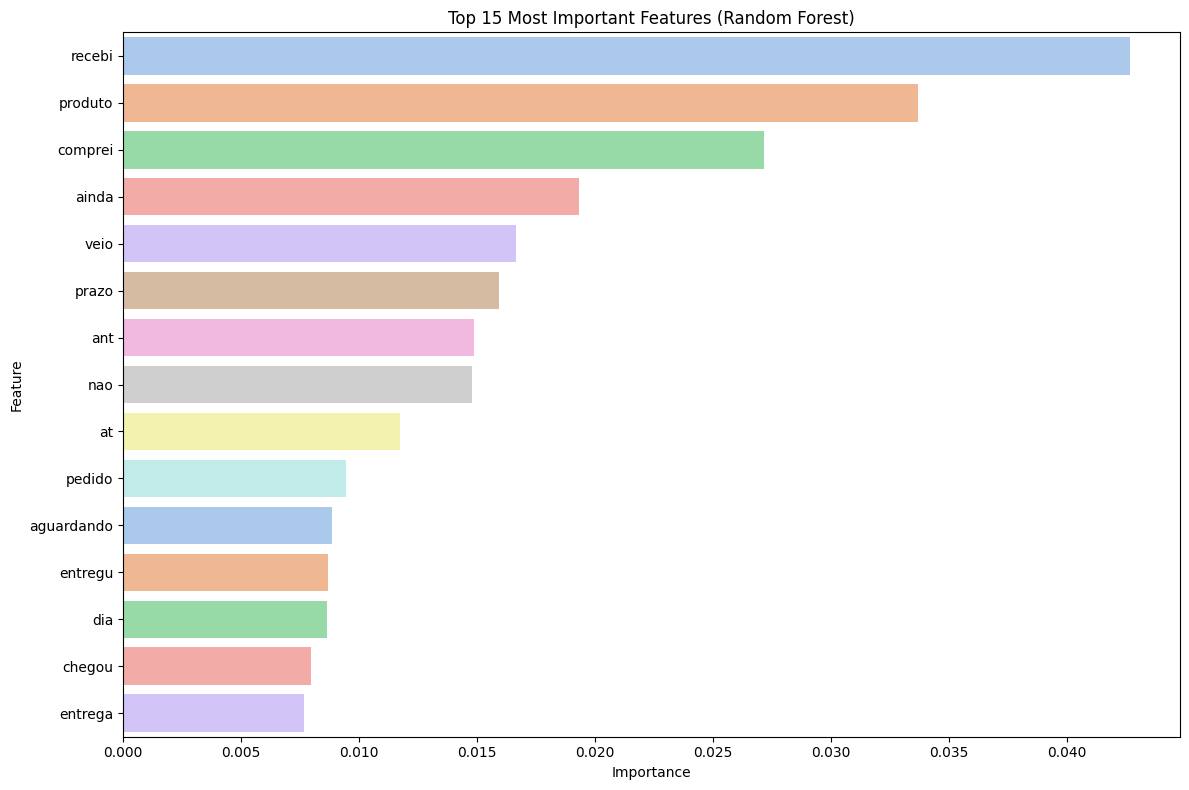

In [91]:
# Visualize the most important features

# Visualize the most important features
plt.figure(figsize=(12, 8))

# Select top 15 features
top_features_rf = feature_importance_rf.head(15)

# Create a bar plot
sns.barplot(x='importance', y='feature', data=top_features_rf, palette='pastel')

plt.title('Top 15 Most Important Features (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## F - Model comparison

/var/folders/hy/m34w8mzj657f1_3lhxh7vfzh0000gp/T/ipykernel_13779/1058517605.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='pastel')


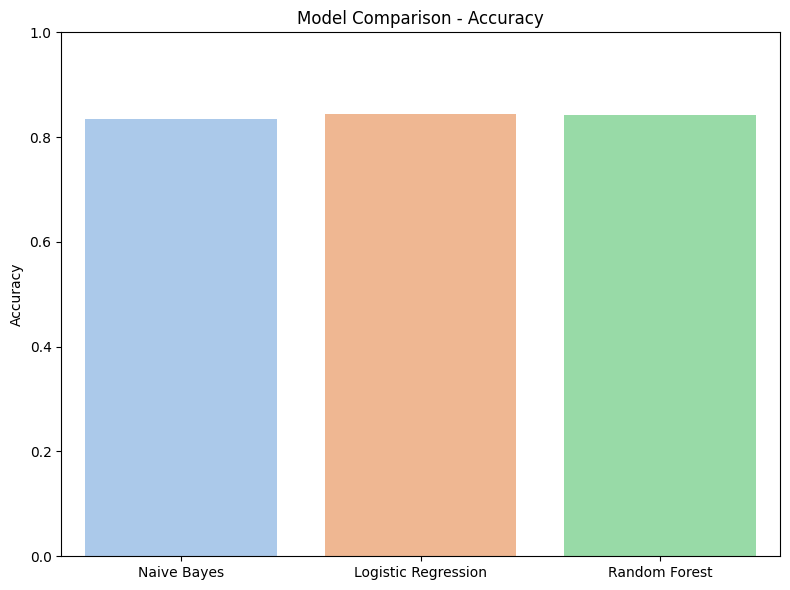

In [92]:

# Compare the performances of the 2 models
models = ['Naive Bayes', 'Logistic Regression', 'Random Forest']
accuracies = [accuracy, accuracy_lr, accuracy_rf]

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies, palette='pastel')

# Add labels and title
plt.title('Model Comparison - Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.tight_layout()
plt.show()


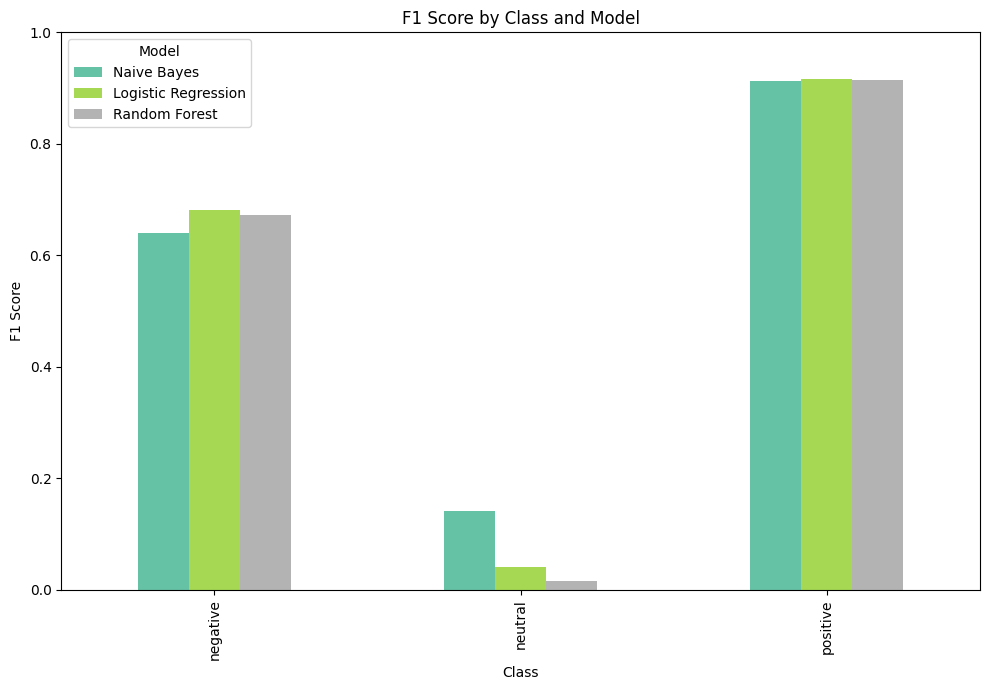

In [93]:
# Compute the F1 score by class (f1_nb, f1_lr, f1_rf)

f1_nb = f1_score(y_test, y_pred, average=None)
f1_lr = f1_score(y_test, y_pred_lr, average=None)
f1_rf = f1_score(y_test, y_pred_rf, average=None)

# Create a dataframe for the visualization
f1_df = pd.DataFrame({
    'Naive Bayes': f1_nb,
    'Logistic Regression': f1_lr,
    'Random Forest': f1_rf
}, index=rf_classifier.classes_)

# Visualize F1 scores by classes

f1_df.plot(kind='bar', figsize=(10, 7), colormap='Set2')

plt.title('F1 Score by Class and Model')
plt.ylabel('F1 Score')
plt.xlabel('Class')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

## G - Example use case: predicting new comments

In [94]:
# Create a function to predict sentiment for new reviews
def predict_sentiment(review_text, vectorizer, model):
    # Preprocess the review
    processed_review = preprocess_text(review_text)
    # Vectorize the review
    review_vector = vectorizer.transform([processed_review])
    # Predict the sentiment
    sentiment = model.predict(review_vector)[0]
    # Get prediction probabilities
    proba = model.predict_proba(review_vector)[0]
    # Return the sentiment and confidence
    return sentiment, proba


In [96]:
# Example reviews to test
example_reviews = [
    "O produto é excelente, superou minhas expectativas!",  # Positive
    "Entrega foi feita no prazo, mas o produto não é tão bom quanto esperava.",  # Neutral
    "Péssimo produto, chegou com defeito e o atendimento ao cliente foi horrível."  # Negative
]

# Predict sentiment for example reviews
print("Predicting sentiment for example reviews:")
for i, review in enumerate(example_reviews):
    sentiment, proba = predict_sentiment(review, tfidf_vectorizer, lr_classifier)
    print(f"\nExample {i+1}: {review}")
    print(f"Predicted sentiment: {sentiment}")
    print(f"Confidence: {max(proba):.2f}")
    print(f"Probabilities: {dict(zip(lr_classifier.classes_, proba))}")
    

Predicting sentiment for example reviews:

Example 1: O produto é excelente, superou minhas expectativas!
Predicted sentiment: positive
Confidence: 1.00
Probabilities: {'negative': 0.0022709163887270453, 'neutral': 0.0026549501084880095, 'positive': 0.995074133502785}

Example 2: Entrega foi feita no prazo, mas o produto não é tão bom quanto esperava.
Predicted sentiment: positive
Confidence: 0.48
Probabilities: {'negative': 0.10469710076465934, 'neutral': 0.4174756803907446, 'positive': 0.477827218844596}

Example 3: Péssimo produto, chegou com defeito e o atendimento ao cliente foi horrível.
Predicted sentiment: negative
Confidence: 0.98
Probabilities: {'negative': 0.9810712877888222, 'neutral': 0.006587141472103299, 'positive': 0.012341570739074475}


# II - Delivery prediction (bonus)

## A - Data preparation

In [ ]:
# We'll use the merged dataframe from previous parts
# If not already done, we need to merge the necessary dataframes
if 'df' not in globals():
    # Load required datasets
    df_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
    df_customers = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
    df_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
    df_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
    
    # Merge datasets
    df = df_orders.merge(df_customers, on='customer_id')
    df = df.merge(df_order_items, on='order_id')
    df = df.merge(df_products, on='product_id')

df.head()


In [ ]:
# Convert date columns to datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 
                'order_delivered_carrier_date', 'order_delivered_customer_date',
                'order_estimated_delivery_date']

for col in date_columns:
    df[col] = pd.to_datetime(df[col])


# Calculate delivery time in days
df['actual_delivery_time'] = (df['order_delivered_customer_date'] - 
                             df['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)

# Calculate if the delivery was delayed (1) or not (0)
df['estimated_delivery_time'] = (df['order_estimated_delivery_date'] - 
                                df['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)
df['is_delayed'] = (df['actual_delivery_time'] > df['estimated_delivery_time']).astype(int)

# Calculate time to carrier in days
df['time_to_carrier'] = (df['order_delivered_carrier_date'] - 
                        df['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)

# Filter out rows with missing delivery dates (canceled orders, etc.)
delivery_df = df.dropna(subset=['order_delivered_customer_date', 'order_delivered_carrier_date'])

delivery_df.head()


In [ ]:
# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='is_delayed', data=delivery_df, palette='viridis')
plt.title('Distribution of Delayed vs On-time Deliveries', fontsize=16)
plt.xlabel('Is Delayed (1 = Yes, 0 = No)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['On-time', 'Delayed'])
for i, count in enumerate(delivery_df['is_delayed'].value_counts()):
    plt.text(i, count + 100, f"{count} ({count/len(delivery_df):.1%})", 
             ha='center', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## B - Feature Engineering

In [ ]:

model_df = delivery_df.copy()

# Extract temporal features
model_df['purchase_hour'] = model_df['order_purchase_timestamp'].dt.hour
model_df['purchase_day'] = model_df['order_purchase_timestamp'].dt.day
model_df['purchase_month'] = model_df['order_purchase_timestamp'].dt.month
model_df['purchase_year'] = model_df['order_purchase_timestamp'].dt.year
model_df['purchase_dayofweek'] = model_df['order_purchase_timestamp'].dt.dayofweek
model_df['purchase_weekend'] = (model_df['purchase_dayofweek'] >= 5).astype(int)

# Calculate distance between customer and seller (using zip code prefix as a proxy)
model_df['zip_distance'] = abs(model_df['customer_zip_code_prefix'] - model_df['seller_zip_code_prefix'])

# Calculate price per weight
model_df['price_per_weight'] = model_df['price'] / model_df['product_weight_g'].replace(0, 0.1)

# Create product volume feature
model_df['product_volume'] = (model_df['product_length_cm'] * 
                             model_df['product_height_cm'] * 
                             model_df['product_width_cm'])

# Handle infinite values
model_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Display the first few rows of the engineered features
print("Sample of engineered features:")
model_df[['purchase_hour', 'purchase_day', 'purchase_month', 'purchase_year', 
                'purchase_dayofweek', 'purchase_weekend', 'zip_distance', 
                'price_per_weight', 'product_volume']].head()

## C - Exploratory Data Analysis for Feature Selection

In [ ]:
# Analyze correlation between features and delivery time with a correlation matrix

'your code here'


In [ ]:
# Analyze categorical features
categorical_features = ['customer_state', 'seller_state', 'product_category_name']

# compute the average delivery time for each of the categorical feature with a bar chart

'your code here'


## D - Feature Selection

In [ ]:
# Select features based on correlation analysis and domain knowledge
selected_numeric_features = ['freight_value', 'price', 'product_weight_g', 
                            'product_volume', 'zip_distance', 'time_to_carrier',
                            'purchase_month', 'purchase_dayofweek']


In [ ]:
# Prepare feature and target variables
X_numeric = model_df[selected_numeric_features]
X_categorical = model_df[selected_categorical_features]
X_combined = pd.concat([X_numeric, X_categorical], axis=1)

# For regression task (predicting delivery time)
y_regression = model_df['actual_delivery_time']

# Split the data
X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X_combined, y_regression, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

## E - Building the Regression Model (Predicting Delivery Time)

In [ ]:
# Define preprocessing for numeric features

'your code here'


In [ ]:
# Create a Linear Regression Pipeline

'your code here'

# Train and evaluate Linear Regression

'your code here'


In [ ]:
# Make predictions based on your linear regression

'your code here'

# Evaluate the model
mae_lr = 'your code here'
rmse_lr = 'your code here'
r2_lr = 'your code here'

print(f"Linear Regression - MAE: {mae_lr:.2f} days")
print(f"Linear Regression - RMSE: {rmse_lr:.2f} days")
print(f"Linear Regression - R²: {r2_lr:.2f}")


the R² should be about 0.40, which is not a good number. Can you do better with a Random Forest model, or any other model? 

Objective is to get a R² > 0.45!

## F - Building a Random Forest model

In [ ]:
'your code here'

### G - Building a K-Nearest Neighbors model

In [ ]:
'your code here'